# Fraud Detection Modeling on Amazon SageMaker - Advanced

Fraud Detection Using Machine Learning enables you to execute automated transaction processing on an example dataset or your own dataset. The included ML model detects potentially fraudulent activity and flags that activity for review.

## AWS Architecture

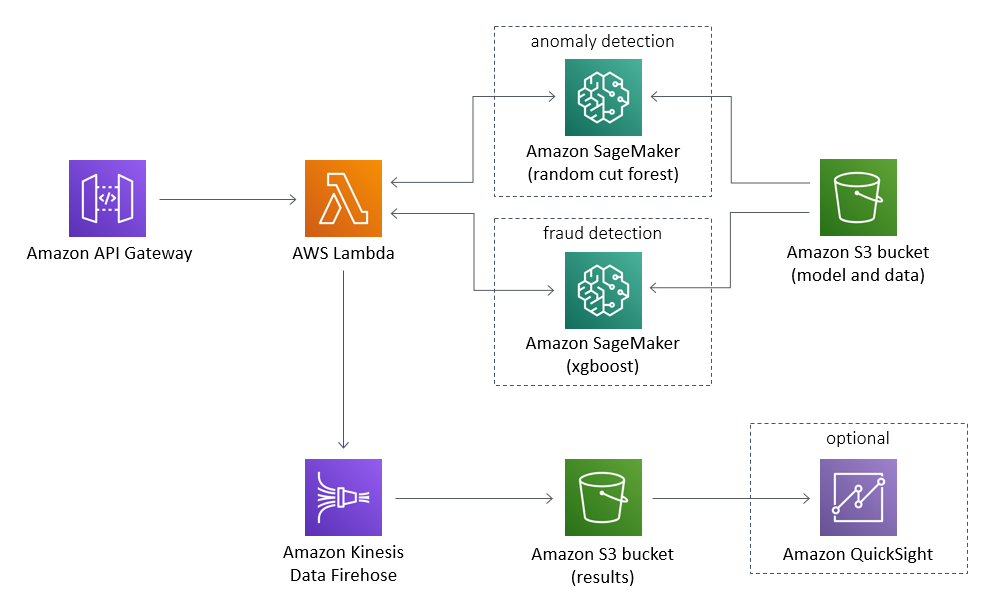

In [1]:
from IPython.display import Image
file_name1 = './img/fraud-detection-using-machine-learning.png'
Image(file_name1)

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
%matplotlib inline
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import jsonlines
import boto3 
import csv
import io
import re
import s3fs
import copy
import random
import time
from time import strftime, gmtime
from scipy.sparse import lil_matrix

# plot aesthetics
import seaborn as sns
sns.set(color_codes=True)
sns.set_context('paper')
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]
sns.set_palette(five_thirty_eight)

%matplotlib inline

from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
from random import shuffle
import random
import datetime
import urllib

import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics

In [3]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'fraud-detec'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000002F569B2CD88>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : fraud-detec
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 1. Load Data

**Data Acknowledgements** 
The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection

In [4]:
# uncomment below code to download data from wget
# %%bash
# wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
# unzip creditcardfraud.zip

In [5]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\github\\amazon-sagemaker\\data'  # Set Your PATH

data = pd.read_csv(os.path.join(path, 'creditcard.csv'), delimiter=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Data Pre-processing

The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulent with only $492$ ($.173\%$) of the data corresponding to fraudulent examples.

In [6]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA.

In [7]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

### 3. Start Training

In [8]:
# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=623)

#### (1) Unsupervised Learning

In a fraud detection scenario, commonly we will have very few labeled examples, and it's possible that labeling fraud takes a very long time. We would like then to extract information from the unlabeled data we have at hand as well. Anomaly detection is a form of unsupervised learning where we try to identify anomalous examples based solely on their feature characteristics. **Random Cut Forest** is a state-of-the-art anomaly detection algorithm that is both accurate and scalable. We will train such a model on our training data and evaluate its performance on our test set.

In [20]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

In [21]:
rcf.fit(rcf.record_set(X_train))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-04 03:51:09 Starting - Starting the training job...
2020-11-04 03:51:11 Starting - Launching requested ML instances......
2020-11-04 03:52:20 Starting - Preparing the instances for training...
2020-11-04 03:53:12 Downloading - Downloading input data...
2020-11-04 03:53:25 Training - Downloading the training image...
2020-11-04 03:54:15 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[11/04/2020 03:54:20 INFO 1

In [24]:
rcf_predictor = rcf.deploy(
    #endpoint_name='random-cut-forest-endpoint',
    initial_instance_count=1,
    instance_type='ml.p2.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: randomcutforest-2020-11-04-03-51-09-065


------------------!

###### Deploy the model

###### Evaluate the model with test set

In [25]:
rcf_predictor.content_type = 'text/csv'
rcf_predictor.serializer = csv_serializer
rcf_predictor.accept = 'application/json'
rcf_predictor.deserializer = json_deserializer

In [26]:
def predict_rcf(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        array_preds = [s['score'] for s in current_predictor.predict(array)['scores']]
        predictions.append(array_preds)

    return np.concatenate([np.array(batch) for batch in predictions])

In [27]:
positives = X_test[y_test == 1]
positives_scores = predict_rcf(rcf_predictor, positives)

negatives = X_test[y_test == 0]
negatives_scores = predict_rcf(rcf_predictor, negatives)

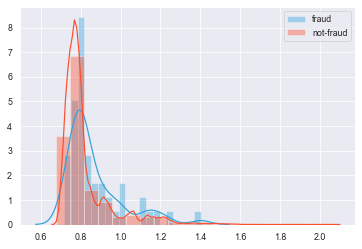

In [29]:
sns.distplot(positives_scores, label='fraud', bins=20)
sns.distplot(negatives_scores, label='not-fraud', bins=20)
plt.legend()

The unsupervised model already can achieve some separation between the classes, with higher anomaly scores being correlated to fraud.

#### (2) Supervised Learning

Once we have gathered an ample amount of labeled training data, we can use a supervised learning algorithm that discovers relationships between the features and the dependent class.

We will use **Gradient Boosted Trees** as our model, as they have a proven track record, are highly scalable and can deal with missing data, reducing the need to pre-process datasets.

In [30]:
# Upload data to S3

In [32]:
import sklearn
from sklearn.datasets import dump_svmlight_file   

key = 'fraud-dataset'

In [45]:
# Convert data to Protobuf (binary stream) and upload to S3.
def writeDatasetToProtobuf(bucket, prefix, key):
    buf = io.BytesIO()
    sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
    
s3_train_data = writeDatasetToProtobuf(bucket, prefix, key)    
print('Uploaded training data location: {}'.format(s3_train_data))

output_location  = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-west-2-570447867175/fraud-detec/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-us-west-2-570447867175/fraud-detec/output


We can now train using SageMaker's built-in XGBoost algorithm. To specify the XGBoost algorithm, we use a utility function to obtain its URI. A complete list of built-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [46]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 
                          'xgboost', 
                          #repo_version='0.90-2'
                         )

	get_image_uri(region, 'xgboost', '1.0-1').


#### Configure the model

In [47]:
from math import sqrt
from sagemaker import get_execution_role

# Because the data set is so highly skewed, we set the scale position weight conservatively,
# as sqrt(num_nonfraud/num_fraud).
# Other recommendations for the scale_pos_weight are setting it to (num_nonfraud/num_fraud).
scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

hyperparameters = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":100,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

clf = sagemaker.estimator.Estimator(container,
                                    role,
                                    hyperparameters=hyperparameters,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

#### Train the model

In [48]:
clf.fit({'train': s3_train_data})

2020-11-04 04:36:24 Starting - Starting the training job...
2020-11-04 04:36:26 Starting - Launching requested ML instances......
2020-11-04 04:37:55 Starting - Preparing the instances for training......
2020-11-04 04:38:54 Downloading - Downloading input data...
2020-11-04 04:39:27 Training - Downloading the training image..
2020-11-04 04:39:46 Training - Training image download completed. Training in progress.Arguments: train
[2020-11-04:04:39:47:INFO] Running standalone xgboost training.
[2020-11-04:04:39:47:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-11-04:04:39:47:INFO] File size need to be processed in the node: 157.49mb. Available memory size in the node: 8470.21mb
[04:39:47] S3DistributionType set as FullyReplicated
[04:39:48] 256326x30 matrix with 7688169 entries loaded from /opt/ml/input/data/train
[04:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=5
[0]#011train-auc:0.95228
[04:39:49] src/tree/upda

#### Deploy the model

In [49]:
predictor = clf.deploy(initial_instance_count=1,
                       endpoint_name="fraud-detection",
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer,
                       deserializer=None,
                       content_type='text/csv')

-------------!

###### Evaluate the model with test set

In [50]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [51]:
raw_preds = predict(predictor, X_test)

In [52]:
raw_preds

array([1.59439478e-05, 4.12945410e-05, 2.02579122e-05, ...,
       1.71951797e-05, 1.62596807e-05, 5.44415816e-05])

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

Two such metrics are the [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score), and [Cohen's Kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa).

In [53]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# scikit-learn expects 0/1 predictions, so we threshold our raw predictions
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, y_preds)))

Balanced accuracy = 0.9037758031479232
Cohen's Kappa = 0.8568975801351875


We can already see that our model performs very well in terms of both metrics, Cohen's Kappa scores above 0.8 are generally very favorable.

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

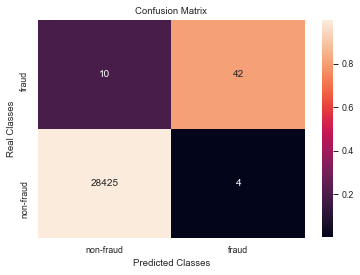

In [55]:
plot_confusion_matrix(y_test, y_preds)

In [56]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     28429
       fraud       0.91      0.81      0.86        52

    accuracy                           1.00     28481
   macro avg       0.96      0.90      0.93     28481
weighted avg       1.00      1.00      1.00     28481



### 4. Keep sending test traffic to the endpoint via lambda

We can now show how we could use both of these models in a production system, using HTTP requests to an AWS Lambda function that invokes both the unsupervised and the supervised SageMaker endpoints.

We create a background thread that will constantly create HTTP requests to invoke the Lambda, using our test data as input. See the included generate_endpoint_traffic.py file to see how that is done. The output will be logged to Kinesis, and you can also observe it in the Lambda function's CloudWatch logs.

In [ ]:
from threading import Thread
from generate_endpoint_traffic import generate_traffic

thread = Thread(target = generate_traffic, args=[np.copy(X_test)])
thread.start()

### 5. Improve Class Imbalance in the dataset and re-train

Now that we have a baseline model using XGBoost, we can try to see if sampling techniques that are designed specifically for imbalanced problems can improve the performance of the model.

For that purpose we will be using the imbalanced-learn package that works well with scikit-learn. We have pre-installed the package for this kernel, but if you need it for a different Jupyter kernel you can install it by running pip install --upgrade imbalanced-learn within the conda environment you need.

We will be using **Sythetic Minority Over-sampling (SMOTE)**, which oversamples the minority class by interpolating new data points between existing ones.

For a detailed information, please refer to this [documentation](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py)

In [58]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [59]:
from collections import Counter
print(sorted(Counter(y_smote).items()))

[(0.0, 255886), (1.0, 255886)]


We note that this is a case of extreme oversampling of the the minority class, we went from ~0.17% to 50%. An alternative would be to use a smaller resampling ratio, such as having one minority cl ass sample for every sqrt(non_fraud/fraud) majority samples, or using more advanced resampling techniques. See the comparison provided by imbalanced-learn for more over-sampling options.

In our case we'll use the SMOTE dataset we just created and upload it to S3 for training.

In [60]:
# Convert data to Protobuf (binary stream) and upload to S3.
def writeDatasetToProtobuf_smote(bucket, prefix, key):
    smote_buf = io.BytesIO()
    
    # Dump the SMOTE data into a buffer
    sklearn.datasets.dump_svmlight_file(X_smote, y_smote, smote_buf)
    smote_buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    
    # Upload from the buffer to S3
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(smote_buf)
    return 's3://{}/{}'.format(bucket,obj)
    
    
s3_smote_train_data = writeDatasetToProtobuf_smote(bucket, prefix, key)    
print('Uploaded training data location: {}'.format(s3_smote_train_data))

smote_output_location  = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(smote_output_location))

Uploaded training data location: s3://sagemaker-us-west-2-570447867175/fraud-detec/fraud-dataset
Training artifacts will be uploaded to: s3://sagemaker-us-west-2-570447867175/fraud-detec/output


In [64]:
try:
    hyperparameters.pop("scale_pos_weight") # No need to scale weights after SMOTE resampling, so we remove that parameter
except KeyError:
    # In case the parameter was already removed, do nothing.
    pass
smote_xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        hyperparameters=hyperparameters,
                                        train_instance_count=1, 
                                        train_instance_type='ml.m4.xlarge',
                                        output_path=smote_output_location,
                                        sagemaker_session=sess)

#### Training with smote-d dataset

In [65]:
smote_xgb.fit({'train': s3_smote_train_data})

2020-11-04 05:11:51 Starting - Starting the training job...
2020-11-04 05:11:53 Starting - Launching requested ML instances......
2020-11-04 05:13:21 Starting - Preparing the instances for training.........
2020-11-04 05:14:32 Downloading - Downloading input data...
2020-11-04 05:15:28 Training - Training image download completed. Training in progress..Arguments: train
[2020-11-04:05:15:29:INFO] Running standalone xgboost training.
[2020-11-04:05:15:29:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-11-04:05:15:29:INFO] File size need to be processed in the node: 314.05mb. Available memory size in the node: 8469.27mb
[05:15:29] S3DistributionType set as FullyReplicated
[05:15:30] 511772x30 matrix with 15350375 entries loaded from /opt/ml/input/data/train
[05:15:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[0]#011train-auc:0.991899
[05:15:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes

#### Deploying the model

In [67]:
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                       endpoint_name="fraud-detection-smote-endpoint",
                       instance_type='ml.m4.xlarge')

-------------!

In [68]:
# Specify input and output formats.
smote_predictor.content_type = 'text/csv'
smote_predictor.serializer = csv_serializer
smote_predictor.deserializer = None

In [69]:
smote_raw_preds = predict(smote_predictor, X_test)
smote_preds = np.where(smote_raw_preds > 0.5, 1, 0)

In [70]:
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_preds)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_preds)))

Balanced accuracy = 0.9130394342721544
Cohen's Kappa = 0.7221177723488154


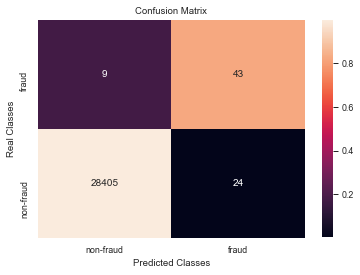

In [71]:
plot_confusion_matrix(y_test, smote_preds)

In [72]:
print(classification_report(
    y_test, smote_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     28429
       fraud       0.64      0.83      0.72        52

    accuracy                           1.00     28481
   macro avg       0.82      0.91      0.86     28481
weighted avg       1.00      1.00      1.00     28481



Due to the randomness of XGBoost your results may vary, but overall, you should see a large increase in non-fraud cases being classified as fraud (false positives). The reason this happens is because SMOTE has oversampled the fraud class so much that it's increased its overlap in feature space with the non-fraud cases. Since Cohen's Kappa gives more weight to false positives than balanced accuracy does, the metric drops significantly, as does the precision and F1 score for fraud cases. However, we can bring a balance between the metrics again by adjusting our classification threshold.

So far we've been using 0.5 as the threshold between labeling a point as fraud or not. We can try different thresholds to see if they affect the result of the classification. To evaluate we'll use the balanced accuracy and Cohen's Kappa metrics.

In [73]:
for thres in np.linspace(0.1, 0.9, num=9):
    smote_thres_preds = np.where(smote_raw_preds > thres, 1, 0)
    print("Threshold: {:.1f}".format(thres))
    print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_test, smote_thres_preds)))
    print("Cohen's Kappa = {:.3f}\n".format(cohen_kappa_score(y_test, smote_thres_preds)))

Threshold: 0.1
Balanced accuracy = 0.921
Cohen's Kappa = 0.434

Threshold: 0.2
Balanced accuracy = 0.922
Cohen's Kappa = 0.598

Threshold: 0.3
Balanced accuracy = 0.922
Cohen's Kappa = 0.661

Threshold: 0.4
Balanced accuracy = 0.913
Cohen's Kappa = 0.699

Threshold: 0.5
Balanced accuracy = 0.913
Cohen's Kappa = 0.722

Threshold: 0.6
Balanced accuracy = 0.913
Cohen's Kappa = 0.747

Threshold: 0.7
Balanced accuracy = 0.913
Cohen's Kappa = 0.796

Threshold: 0.8
Balanced accuracy = 0.913
Cohen's Kappa = 0.827

Threshold: 0.9
Balanced accuracy = 0.913
Cohen's Kappa = 0.851



We see that Cohen's Kappa keeps increasing along with the threshold, without a significant loss in balanced accuracy. This adds a useful knob to our model: We can keep a low threshold if we care more about not missing any fraudulent cases, or we can increase the threshold to try to minimize the number of false positives.

### 13. Close the SageMaker Instance

We will leave the unsupervised and base XGBoost endpoints running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoints when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run predictor_name.delete_endpoint()

In [75]:
# Uncomment below to clean up endpoints
#rcf_predictor.delete_endpoint()
#predictor.delete_endpoint()
smote_predictor.delete_endpoint()

Reference
>https://aws.amazon.com/solutions/implementations/fraud-detection-using-machine-learning/